In [ ]:
# https://github.com/GeospatialGeeks/Satellite-Image-Building-Segmentation
# mount drive, turn on GPU runtime
%load_ext autoreload
%autoreload 2
%matplotlib inline
import PIL, os, mimetypes
from fastai.vision import *
from fastai.utils.collect_env import *
Path.ls = lambda x: list(x.iterdir())
show_install(True)

In [15]:
imgsdir = Path('/content/fastai/segbldg/images')
imgsname = get_image_files(imgsdir)
lblsdir = Path('/content/fastai/segbldg/labels')
lblsname = get_image_files(imgsdir)
get_y_fn = lambda x:lblsdir/f'{x.stem}{x.suffix}'


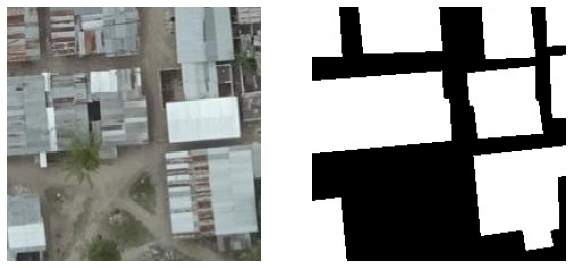

In [33]:
testindex = 2
imgtest = open_image(imgsname[testindex])
lbltest = open_image(get_y_fn(imgsname[testindex]), div=True)
fig,ax = plt.subplots(1,2, figsize=(10,10))
imgtest.show(ax=ax[0])
lbltest.show(ax=ax[1], alpha=0)

In [34]:
ax

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fa32c8d4cf8>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7fa32d95de10>], dtype=object)